In [309]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, RobustScaler

# Detecting market regimes

In [310]:
df = pd.read_csv('data/data_preprocessed.csv', index_col=0, parse_dates=True)
log_returns = np.log(df / df.shift(1)).dropna()

In [320]:
# Base features
features = pd.DataFrame(index=log_returns.index)
features['mean_return']   = log_returns.mean(axis=1)
features['volatility']    = log_returns.std(axis=1)
#features['median_return'] = log_returns.median(axis=1)
#features['iqr']           = (log_returns.quantile(0.75, axis=1) - log_returns.quantile(0.25, axis=1))
#features['skewness']      = log_returns.skew(axis=1)
#features['kurtosis']      = log_returns.kurtosis(axis=1)
features['up_frac']       = (log_returns > 0).mean(axis=1)

# Correct drawdown calculation
rolling_peak = df.cummax()               # highest price-to-date
drawdown     = df.div(rolling_peak) - 1  # percent below peak

features['max_drawdown']  = drawdown.min(axis=1)        # worst drop across assets

# Add 1‐ and 2‐day lags without dropping rows
#lags = [1, 2]
#cols_to_lag = ['mean_return', 'volatility', 'max_drawdown']
#for lag in lags:
#    for col in cols_to_lag:
#        features[f'{col}_lag{lag}'] = features[col].shift(lag)

# Fill NaNs from the shifts to keep same row count
#features.bfill(inplace=True)
#features.ffill(inplace=True)

In [321]:
features

,mean_return,volatility,up_frac,max_drawdown
timestamp,,,,
2017-03-08,-0.012348,0.025446,0.248521,-0.109702
2017-03-09,-0.004321,0.013187,0.331361,-0.150350
2017-03-14,0.001178,0.019119,0.550296,-0.187583
2017-03-20,0.011657,0.030887,0.810651,-0.239511
2017-03-21,-0.007886,0.023945,0.325444,-0.200125
...,...,...,...,...
2023-01-05,-0.003569,0.029990,0.343195,-0.999222
2023-01-06,0.014127,0.021099,0.881657,-0.999282
2023-01-09,0.013946,0.032685,0.822485,-0.999383


In [313]:
# Cluster days into 3 regimes

kmeans = KMeans(n_clusters=3, random_state=45)
labels = kmeans.fit_predict(features)

# Map cluster IDs → regime names (Bear < Risky < Bull by mean_return)
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=features.columns
)

ordered_ids = centers['mean_return'].sort_values().index.tolist()

regime_map = {
    ordered_ids[0]: 'Bear',    # lowest mean_return
    ordered_ids[1]: 'Risky',   # middle
    ordered_ids[2]: 'Bull'     # highest mean_return
}

regimes = pd.Series(labels, index=features.index).map(regime_map)

print(regimes.value_counts())


Bull     721
Bear     609
Risky    116
Name: count, dtype: int64


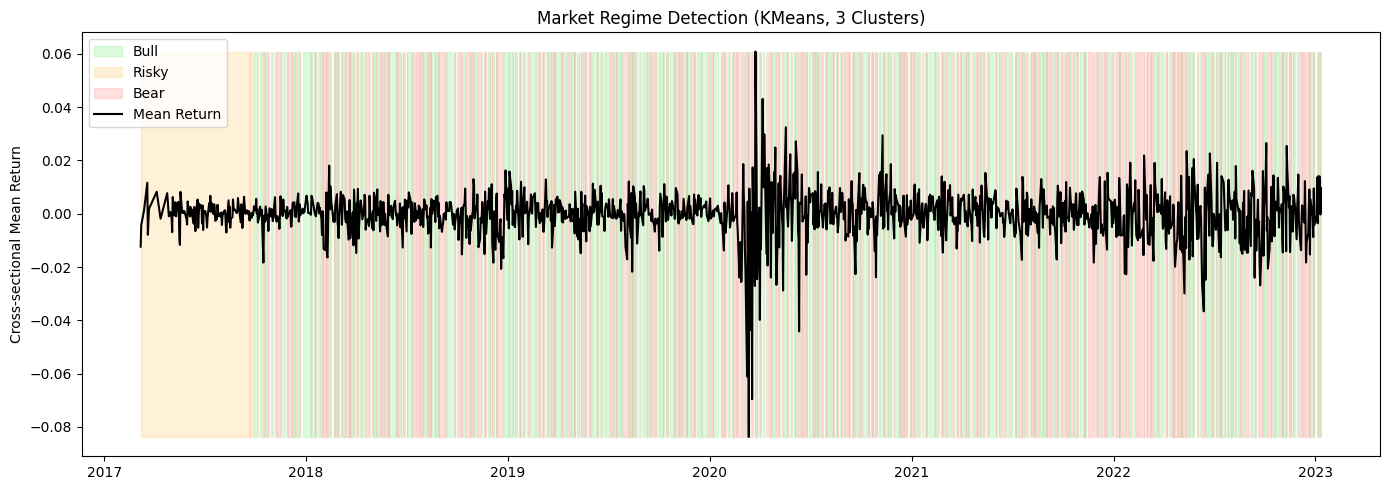

In [314]:
# Plot regimes over the mean_return series
plt.figure(figsize=(14, 5))
ymin, ymax = features['mean_return'].min(), features['mean_return'].max()

for regime, color in zip(['Bull', 'Risky', 'Bear'], ['#90ee90', '#ffd27f', '#ff9999']):
    mask = (regimes == regime)
    plt.fill_between(
        features.index, ymin, ymax,
        where=mask, color=color, alpha=0.3, label=regime
    )

plt.plot(features.index, features['mean_return'], color='k', lw=1.5, label='Mean Return')
plt.title('Market Regime Detection (KMeans, 3 Clusters)')
plt.ylabel('Cross-sectional Mean Return')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [315]:
# Silhouette score
sil_score = silhouette_score(features, labels)
print(f"Silhouette score: {sil_score:.3f}")

Silhouette score: 0.519


We tried scaling the features before scaling but it hurt the silhouette score so bad. We decided to skip it since the features are somewhat in a comparable scale.

Also, we managed to have silhouette score of 0.72 by adding features (kurtosis and skewness), but in this case it was not really interesting for the data augmentation part as we had most data points in the risky regime.

# Data augmentation

In [316]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

Bear Ep 100/1000 loss=41.9663
Bear Ep 200/1000 loss=33.3241
Bear Ep 300/1000 loss=30.3666
Bear Ep 400/1000 loss=25.9556
Bear Ep 500/1000 loss=24.2788
Bear Ep 600/1000 loss=23.1820
Bear Ep 700/1000 loss=21.8655
Bear Ep 800/1000 loss=21.4508
Bear Ep 900/1000 loss=21.0603
Bear Ep 1000/1000 loss=19.9885


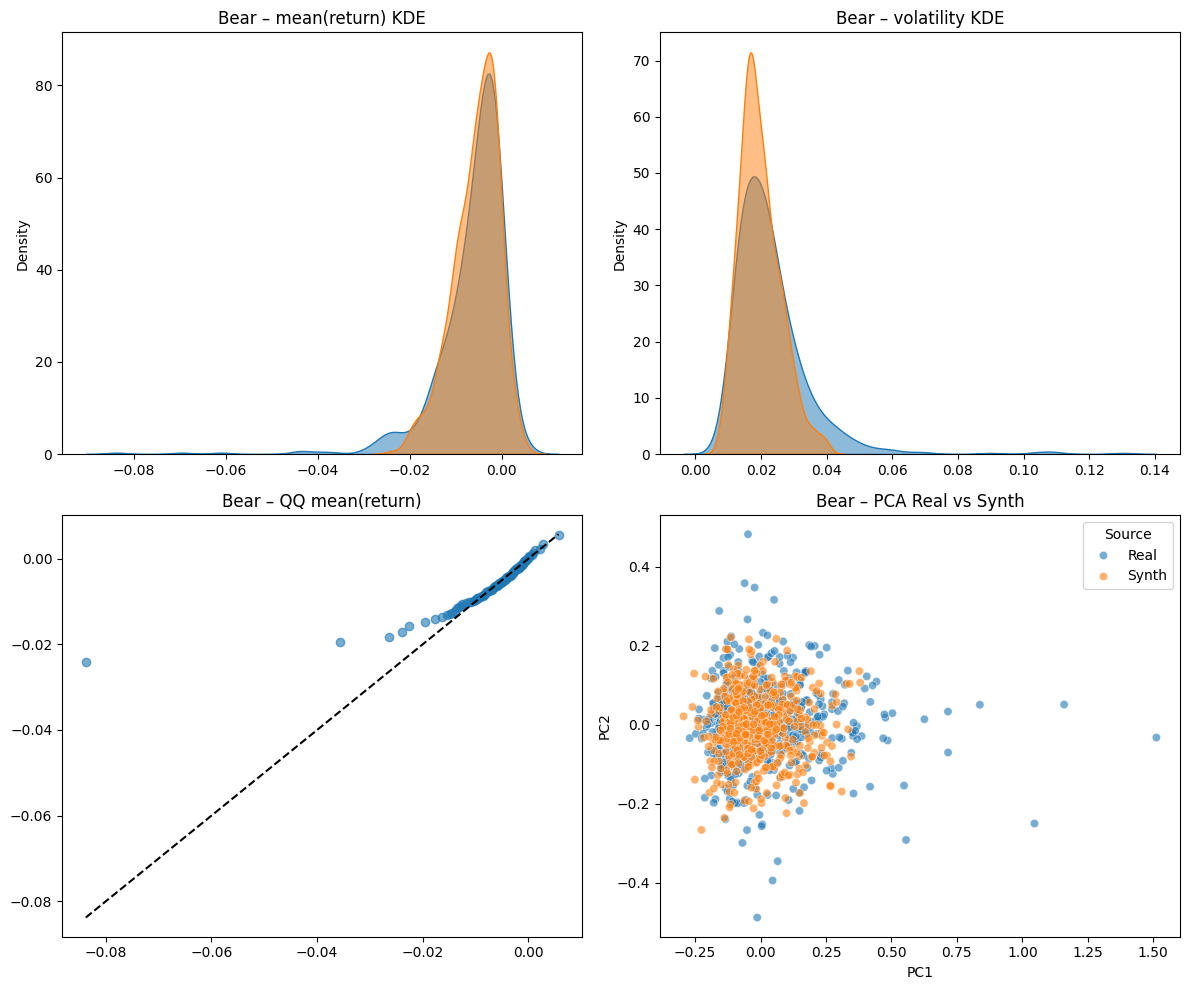

Risky Ep 100/1000 loss=19.7290
Risky Ep 200/1000 loss=11.5680
Risky Ep 300/1000 loss=8.6462
Risky Ep 400/1000 loss=7.2535
Risky Ep 500/1000 loss=6.4882
Risky Ep 600/1000 loss=5.9265
Risky Ep 700/1000 loss=6.0263
Risky Ep 800/1000 loss=5.9081
Risky Ep 900/1000 loss=5.5694
Risky Ep 1000/1000 loss=5.5691


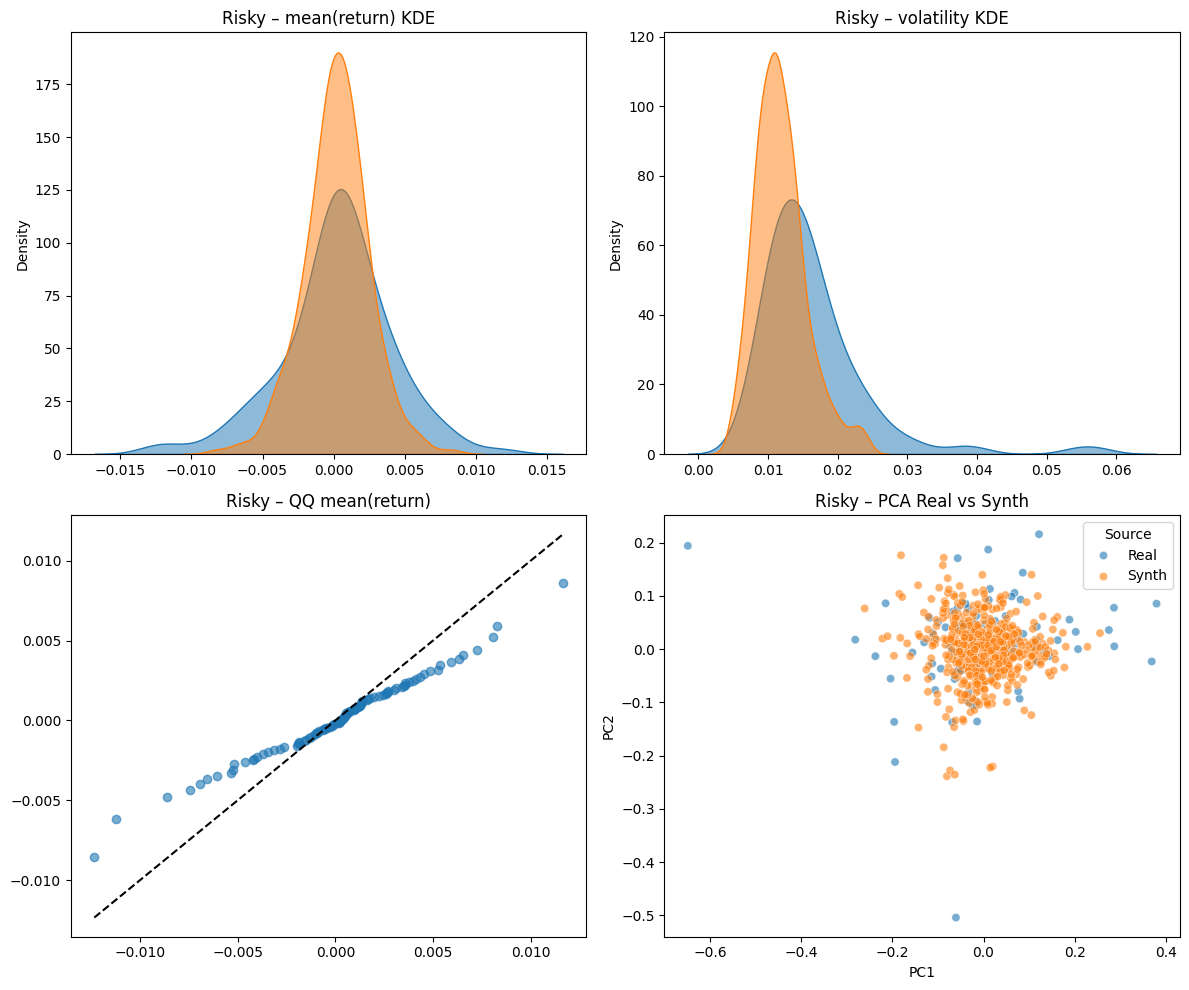

Bull Ep 100/1000 loss=38.2235
Bull Ep 200/1000 loss=30.1752
Bull Ep 300/1000 loss=27.0541
Bull Ep 400/1000 loss=24.4646
Bull Ep 500/1000 loss=23.5134
Bull Ep 600/1000 loss=22.2466
Bull Ep 700/1000 loss=22.4987
Bull Ep 800/1000 loss=21.0727
Bull Ep 900/1000 loss=20.7291
Bull Ep 1000/1000 loss=21.0403


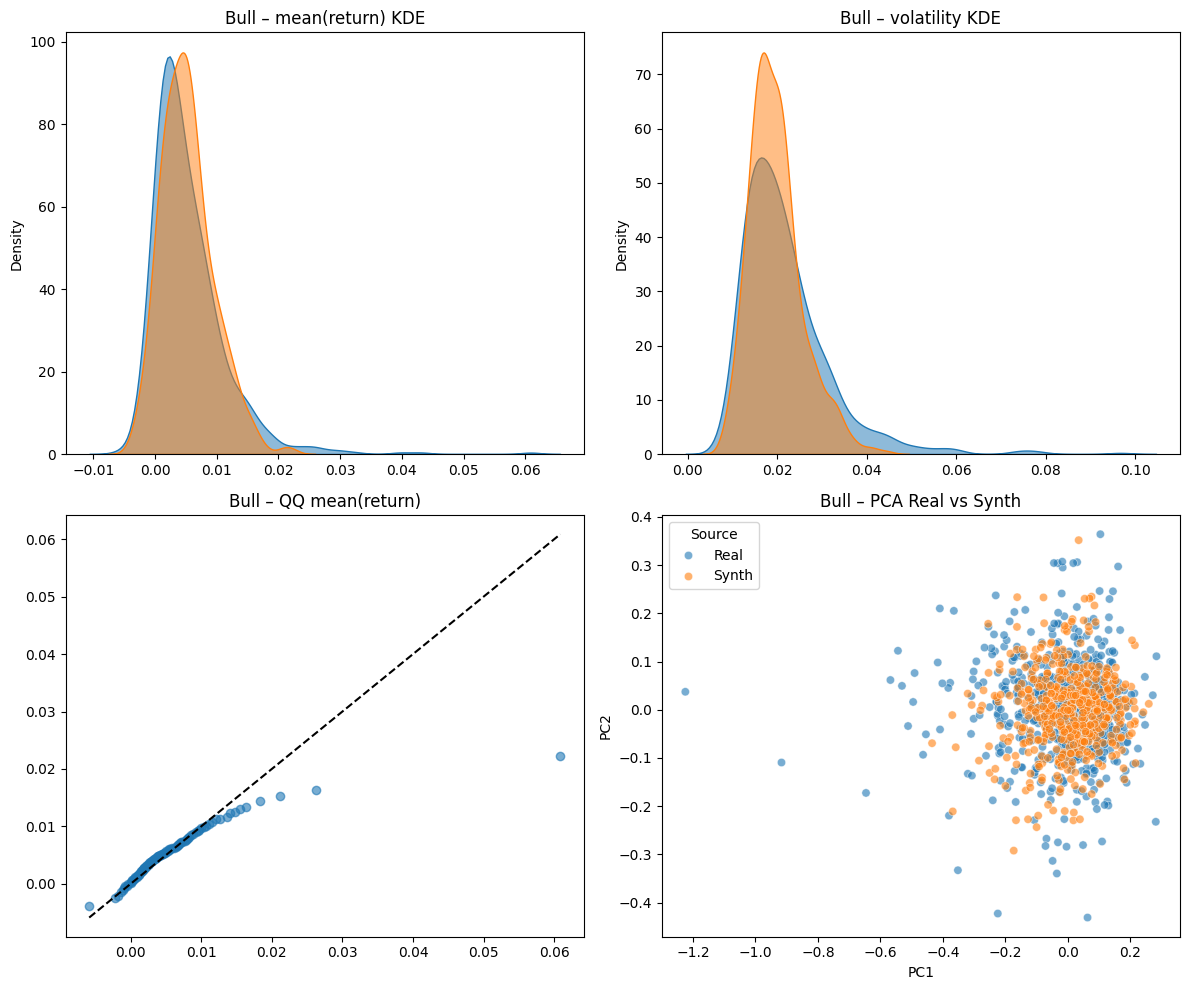

Augmented price panel shape: (2947, 169)


In [317]:
# Load prices & regimes
df = pd.read_csv('data/data_preprocessed.csv', index_col=0, parse_dates=True)
logr = np.log(df / df.shift(1)).dropna()

# Scale log-returns for VAE input
scaler = StandardScaler()
returns_scaled = pd.DataFrame(
    scaler.fit_transform(logr),
    index=logr.index,
    columns=logr.columns
)

# Your exact BetaVAE definition
class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=10, beta=0.2):
        super().__init__()
        self.beta = beta
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu    = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar= nn.Linear(hidden_dim, latent_dim)
        self.dec1 = nn.Linear(latent_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.out  = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = F.relu(self.enc1(x)); h = F.relu(self.enc2(h))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp(); eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = F.relu(self.dec1(z)); h = F.relu(self.dec2(h))
        return self.out(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon, x, mu, logvar, beta):
    re  = F.mse_loss(recon, x, reduction='sum')
    kl  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return re + beta * kl

# plotting
def assess_visual(real_df, synth_df, regime_name):
    combined = pd.concat([real_df.assign(Source='Real'),
                          synth_df.assign(Source='Synth')])
    coords = PCA(n_components=2).fit_transform(combined[real_df.columns])
    df_pca = pd.DataFrame(coords, columns=['PC1','PC2'])
    df_pca['Source'] = combined['Source'].values

    fig, axes = plt.subplots(2,2, figsize=(12,10))
    sns.kdeplot(real_df.mean(axis=1), ax=axes[0,0], label='Real', fill=True, alpha=0.5)
    sns.kdeplot(synth_df.mean(axis=1), ax=axes[0,0], label='Synth', fill=True, alpha=0.5)
    axes[0,0].set_title(f'{regime_name} – mean(return) KDE')
    sns.kdeplot(real_df.std(axis=1), ax=axes[0,1], label='Real', fill=True, alpha=0.5)
    sns.kdeplot(synth_df.std(axis=1), ax=axes[0,1], label='Synth', fill=True, alpha=0.5)
    axes[0,1].set_title(f'{regime_name} – volatility KDE')

    # QQ for mean
    q = np.linspace(0,1,100)
    rq = np.quantile(real_df.mean(axis=1), q)
    sq = np.quantile(synth_df.mean(axis=1), q)
    axes[1,0].scatter(rq, sq, alpha=0.6)
    mmin, mmax = min(rq.min(), sq.min()), max(rq.max(), sq.max())
    axes[1,0].plot([mmin,mmax],[mmin,mmax],'k--')
    axes[1,0].set_title(f'{regime_name} – QQ mean(return)')

    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Source', alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title(f'{regime_name} – PCA Real vs Synth')
    plt.tight_layout(); plt.show()

# Train per regime on RETURNS, generate synthetic RETURNS and PRICES
input_dim = returns_scaled.shape[1]
epochs, batch_size, n_samples = 1000, 32, 500
last_prices = df.iloc[-1]
augmented_prices = [df.copy()]  # start with real price panel

for regime in ['Bear','Risky','Bull']:
    X = returns_scaled[regimes==regime].values
    ds = TensorDataset(torch.from_numpy(X).float())
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    model = BetaVAE(input_dim, 128, 10, beta=0.2)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for ep in range(epochs):
        L=0
        for (batch,) in dl:
            opt.zero_grad()
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar, model.beta)
            loss.backward(); opt.step()
            L+=loss.item()
        if (ep+1)%100==0:
            print(f"{regime} Ep {ep+1}/{epochs} loss={L/len(ds):.4f}")

    model.eval()
    with torch.no_grad():
        Z = torch.randn(n_samples, model.fc_mu.out_features)
        synth_scaled = model.decode(Z).numpy()

    # invert scale => synthetic returns
    synth_returns = pd.DataFrame(
        scaler.inverse_transform(synth_scaled),
        columns=logr.columns
    )
    # visualize in return‐space
    real_ret = logr[regimes==regime]
    assess_visual(real_ret, synth_returns, regime)

    # build synthetic price paths (one step beyond last real day)
    start = df.index.max() + pd.Timedelta(days=1)
    dates = pd.date_range(start, periods=n_samples, freq='B')
    synth_prices = synth_returns.cumsum().apply(np.exp).mul(last_prices, axis=1)
    synth_prices.index = dates
    augmented_prices.append(synth_prices)

# Final augmented price panel
augmented_df = pd.concat(augmented_prices)
print("Augmented price panel shape:", augmented_df.shape)
augmented_df.to_csv('data/augmented_prices.csv')


In [318]:
augmented_df

,CSCO,SPXU,UAL,SPLG,MRO,TIP,CS,USMV,CTRA,ESGE,...,PBR.A,SLV,LABU,M,CRM,PDBC,EELV,SPTL,KWEB,PPL
2017-03-02,28.545556,321.323333,73.674300,100.609091,15.065926,94.927407,13.568519,43.123704,19.161111,25.923333,...,6.500037,17.009685,5.303519e+01,25.068889,82.684533,9.137407,17.729167,60.312609,35.803077,27.345185
2017-03-08,28.293704,328.484444,73.139522,100.026667,14.346667,94.505926,13.303704,42.751481,19.515926,26.026667,...,6.306259,16.356359,5.131778e+01,23.867778,83.556793,8.997462,17.838947,59.703182,36.569259,27.017037
2017-03-09,28.253333,330.135556,73.215370,99.701250,14.476296,94.270000,13.349259,42.734074,19.181481,25.734000,...,6.074074,16.148278,5.139852e+01,23.865185,83.286130,8.814885,17.700000,59.446667,36.133333,27.079630
2017-03-14,28.298462,329.938148,67.317304,99.686000,14.130370,94.154783,13.306522,42.835652,19.054348,26.225000,...,5.878333,16.039242,5.108750e+01,23.675000,83.148333,8.677522,17.937143,59.466250,37.020000,27.293478
2017-03-20,28.488000,325.258462,67.514200,100.210000,14.256400,95.149615,13.376087,43.167826,19.148333,27.222500,...,5.890652,16.498544,5.124783e+01,22.660400,83.154200,8.800478,18.636364,60.388125,38.119565,27.602500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05,1940.974598,0.000622,50415.659908,1583.072522,29074.413009,128.848418,167.049489,687.176478,71.390037,837.421909,...,1117.921174,203.996256,2.017267e+06,4361.878030,5178.636562,128.402926,220.231914,14.265170,4416.290975,298.846628
2024-12-06,1972.576784,0.000608,50892.378929,1596.835826,28311.136781,129.256269,164.301132,690.463008,70.507972,847.416595,...,1111.509843,204.112433,2.226141e+06,4511.180475,5179.797102,128.169407,221.348949,14.390852,4531.394836,293.358682
2024-12-09,2012.501738,0.000584,52070.519657,1621.275233,28348.760017,129.032205,166.519183,700.895058,73.001101,850.129473,...,1112.075490,202.032912,2.299481e+06,4690.241187,5268.114057,125.456269,222.598911,14.423491,4554.337441,300.607124
2024-12-10,2037.500125,0.000569,52033.664699,1634.662806,28826.688889,128.811472,168.092835,707.101119,75.553671,848.604826,...,1137.646654,200.174985,2.249229e+06,4879.775187,5357.066453,125.417557,223.116017,14.332206,4518.897087,305.439868
